Here, we'll test how dynamically novel the components of the CST- and RTT-unique spaces are.

First, load the data and split the subspaces out:

In [1]:
#| output: false
import src
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

td = pd.read_pickle('../results/dekodec/Prez_20220721_dekodec_split.pkl')
td.columns

Index(['M1_spikes', 'M1_unit_guide', 'MC_spikes', 'MC_unit_guide',
       'PMd_spikes', 'PMd_unit_guide', 'bin_size', 'cst_cursor_command',
       'ct_location', 'cursor_pos', 'date_time', 'hand_pos', 'idx_cstEndTime',
       'idx_cstStartTime', 'idx_ctHoldTime', 'idx_endTime', 'idx_failTime',
       'idx_goCueTime', 'idx_pretaskHoldTime', 'idx_rewardTime',
       'idx_rtHoldTimes', 'idx_rtgoCueTimes', 'idx_startTime', 'lambda',
       'monkey', 'raw_left_eye_pos', 'raw_left_pupil', 'rel_cursor_pos',
       'rel_hand_pos', 'result', 'rt_locations', 'task', 'trial_id',
       'session_date', 'M1_rates', 'MC_rates', 'PMd_rates', 'lfads_rates',
       'lfads_inputs', 'hand_vel', 'hand_acc', 'cursor_vel', 'hand_speed',
       'Time from go cue (s)', 'Time from task cue (s)', 'trialtime',
       'lfads_rates_joint_pca', 'lfads_rates_joint_pca_cst_unique',
       'lfads_rates_joint_pca_rtt_unique', 'lfads_rates_joint_pca_shared',
       'lfads_rates_joint_pca_split'],
      dtype='object')

Let's double-check that the split worked satisfactorily with a variance plot.

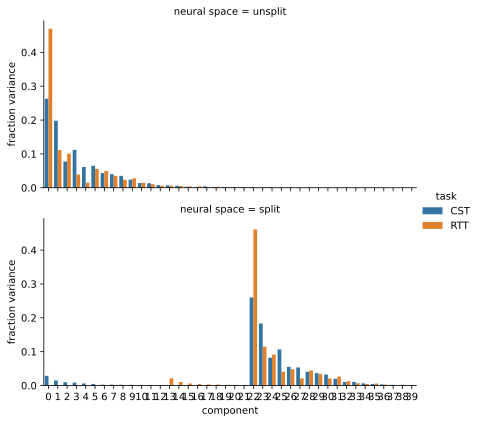

In [2]:
src.plot.plot_split_subspace_variance(td,signal='lfads_rates_joint_pca')

How much of the variance in the unique spaces is explained by correlations with the shared space activity? Let's do a linear regression to find out.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

signal = 'lfads_rates_joint_pca'
num_shared_comps = 10
num_unique_comps = 6

stacked_activity = (
    td
    .groupby('task')
    [[f'{signal}_cst_unique',f'{signal}_rtt_unique',f'{signal}_shared']]
    .agg(np.row_stack)
)

def check_dynamic_commonality(regressor,target):
    model = LinearRegression(fit_intercept=False)
    pred = model.fit(regressor,target).predict(regressor)
    return r2_score(target,pred,multioutput='variance_weighted')

def get_task_shared_unique_activity(task):
    unique_act,shared_act = stacked_activity.loc[task,[f'{signal}_{task.lower()}_unique',f'{signal}_shared']]
    return unique_act,shared_act

def task_shared_commonality(task):
    unique_act,shared_act = get_task_shared_unique_activity(task)
    print(f'{task} unique: {check_dynamic_commonality(shared_act[:,:10],unique_act[:,:num_unique_comps])}')
    print(f'{task} shared: {check_dynamic_commonality(unique_act[:,:6],shared_act[:,:num_shared_comps])}')

task_shared_commonality('CST')
task_shared_commonality('RTT')

Seems like there's a good amount of dynamic commonality. Specifically, it looks like the unique spaces, which are lower variance and lower dimensional, are reasonably well explained by the shared space activity during each task (though not fully). This means that there is some projection of the shared space activity during each task that explains most of the unique space activity.

It would be interesting to know whether the potent space of this projection is the same for both tasks, so next, let's check on that.

The way we'll do it is to find the activity in the shared space that explains the unique space activity (the potent space of the linear map between shared and unique activity) and find how much of the total shared space variance that potent space explains. If the potent space is similar between tasks, then each task's potent space should explain a similar amount of the shared space variance.

In [ ]:
rtt_unique,rtt_shared = get_task_shared_unique_activity('RTT')
rtt_shared_potent,rtt_shared_null = src.subspace_tools.find_potent_null_space(rtt_shared[:,:num_shared_comps],rtt_unique[:,:num_unique_comps])
cst_unique,cst_shared = get_task_shared_unique_activity('CST')
cst_shared_potent,cst_shared_null = src.subspace_tools.find_potent_null_space(cst_shared[:,:num_shared_comps],cst_unique[:,:num_unique_comps])

rtt_potent_frac_var_rtt = src.subspace_tools.frac_var_explained_by_subspace(rtt_shared[:,:num_shared_comps], rtt_shared_potent)
cst_potent_frac_var_rtt = src.subspace_tools.frac_var_explained_by_subspace(rtt_shared[:,:num_shared_comps], cst_shared_potent)
cst_potent_frac_var_cst = src.subspace_tools.frac_var_explained_by_subspace(cst_shared[:,:num_shared_comps], cst_shared_potent)
rtt_potent_frac_var_cst = src.subspace_tools.frac_var_explained_by_subspace(cst_shared[:,:num_shared_comps], rtt_shared_potent)

print(f'Fraction RTT shared space variance in CST potent space (normalized by RTT potent space var) : {cst_potent_frac_var_rtt/rtt_potent_frac_var_rtt}')
print(f'Fraction CST shared space variance in RTT potent space (normalized by CST potent space var) : {rtt_potent_frac_var_cst/cst_potent_frac_var_cst}')

Not sure how to interpret this. It seems as though the potent space of the shared space activity during the CST task is similar to the RTT potent space of the shared space. But during RTT, more of the shared space variance is outside the CST shared-unique potent space than outside the RTT shared-unique potent space. It's a bit difficult to come up with a concise story just from this.

Let's try to find the components of the unique spaces that are least correlated with the shared space activity. We'll do this iteratively, using pymanopt.

In [ ]:
import pymanopt
import torch

def find_least_predictable_component(X,y):

    lm = LinearRegression(fit_intercept=False)
    y_hat = lm.fit(X,y).predict(X)
    err = y - y_hat
    err_cov = torch.from_numpy(np.cov(err,rowvar=False))
    y_cov = torch.from_numpy(np.cov(y,rowvar=False))

    manifold = pymanopt.manifolds.Sphere(y.shape[1])
    @pymanopt.function.pytorch(manifold)
    def cost(u):
        return -(u.T @ err_cov @ u) / (u.T @ y_cov @ u)

    problem = pymanopt.Problem(manifold=manifold, cost=cost)
    optimizer = pymanopt.optimizers.TrustRegions()
    result = optimizer.run(problem)

    return result.point, lm.coef_

u_cst,shared_coef = find_least_predictable_component(
    cst_shared[:,:num_shared_comps],
    cst_unique[:,:num_unique_comps]
)
td['lfads_rates_joint_pca_cst_unique_unpredictable'] = [x[:,:num_unique_comps] @ u_cst[:,None] for x in td['lfads_rates_joint_pca_cst_unique']]
td['lfads_rates_joint_pca_cst_unique_predicted'] = [x[:,:num_shared_comps] @ shared_coef.T @ u_cst[:,None] for x in td['lfads_rates_joint_pca_shared']]

u_rtt,shared_coef = find_least_predictable_component(
    rtt_shared[:,:num_shared_comps],
    rtt_unique[:,:num_unique_comps]
)
td['lfads_rates_joint_pca_rtt_unique_unpredictable'] = [x[:,:num_unique_comps] @ u_rtt[:,None] for x in td['lfads_rates_joint_pca_rtt_unique']]
td['lfads_rates_joint_pca_rtt_unique_predicted'] = [x[:,:num_shared_comps] @ shared_coef.T @ u_rtt[:,None] for x in td['lfads_rates_joint_pca_shared']]

In [ ]:
def plot_trial_split_space(trial_to_plot,ax_list):
    src.plot.plot_hand_trace(trial_to_plot,ax=ax_list[0],timesig='Time from go cue (s)')
    src.plot.plot_hand_velocity(trial_to_plot,ax_list[1],timesig='Time from go cue (s)')

    sig_list = [
        #f'{signal}_cst_unique_unpredictable',
        f'{signal}_rtt_unique_unpredictable',
        #f'{signal}_cst_unique_predicted',
        f'{signal}_rtt_unique_predicted',
        # f'{signal}_rtt_unique',
        # f'{signal}_shared',
    ]
    sig_dims = {
        f'{signal}_cst_unique': num_unique_comps,
        f'{signal}_rtt_unique': num_unique_comps,
        f'{signal}_cst_unique_unpredictable': 1,
        f'{signal}_rtt_unique_unpredictable': 1,
        f'{signal}_cst_unique_predicted': 1,
        f'{signal}_rtt_unique_predicted': 1,
        f'{signal}_shared': num_shared_comps,
    }
    sig_colors = {
        f'{signal}_cst_unique':'C0',
        f'{signal}_rtt_unique':'C1',
        f'{signal}_rtt_unique_unpredictable':'C3',
        f'{signal}_cst_unique_unpredictable':'C5',
        f'{signal}_rtt_unique_predicted':'C3',
        f'{signal}_cst_unique_predicted':'C5',
        f'{signal}_shared': 'C4',
    }

    rownum = 2
    for sig in sig_list:
        for dim in range(sig_dims[sig]):
            ax = ax_list[rownum]
            ax.plot(trial_to_plot['Time from go cue (s)'][[0,-1]],[0,0],color='k')
            ax.plot(trial_to_plot['Time from go cue (s)'],trial_to_plot[sig][:,dim],color=sig_colors[sig])
            # ax.set_yticks([])
            ax.plot([0,0],ax.get_ylim(),color='k',linestyle='--')
            sns.despine(ax=ax,trim=True)
            rownum+=1

    ax_list[-1].set_xlabel('Time from go cue (s)')

trials_to_plot = td.groupby('task').sample(n=1).set_index('trial_id')
fig,axs = plt.subplots(4,len(trials_to_plot),sharex=True,sharey='row',figsize=(8,6))
fig.tight_layout()
for colnum,(trial_id,trial) in enumerate(trials_to_plot.iterrows()):
    plot_trial_split_space(trial,axs[:,colnum])

In [ ]:
unique_frac_var=np.var(unique_act,axis=0)/np.var(np.column_stack([unique_act,shared_act]),axis=0).sum()
shared_frac_var=np.var(shared_act,axis=0)/np.var(np.column_stack([unique_act,shared_act]),axis=0).sum()
fig,ax = plt.subplots(2,1)
ax[0].plot(unique_frac_var)
ax[1].plot(shared_frac_var)
shared_frac_var